<a href="https://colab.research.google.com/github/yashinaniya/Amazon-review-classification-using-Tensorflow/blob/main/Amazon_reviews_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements sentiment analysis on Amazon reviews dataset. In this notebook I have used the Mobile_Electronics products subset of the large [Amazon customer reviews dataset](https://s3.amazonaws.com/amazon-reviews-pds/readme.html). 

The dataset is loaded directly through the tensorflow module:  tensorflow_datasets. We try three different models to do the sentiment analysis:
1) Neural network using Keras and LSTM Layers
2) Gaussian Naive Bayes classifier
3) Simple Logistic Regression .

The accuracy is high with Deep learning model and Logistic Regression in comparison to Naive Bayes. Feel free to try other models also like Random Forest, SVM. 

In [ ]:

# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

**Import the required libraries**

# Import the required Libraries

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [ ]:
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import tensorflow_datasets as tfds

# Load the dataset using tfds.load

In [ ]:
ds = tfds.load('amazon_us_reviews/Mobile_Electronics_v1_00', split='train', shuffle_files=True)
assert isinstance(ds, tf.data.Dataset)
print(ds)


Shuffling and writing examples to /root/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0.incomplete2VVUDR/amazon_us_reviews-train.tfrecord


Dataset amazon_us_reviews downloaded and prepared to /root/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0. Subsequent calls will reuse this data.
<_OptionsDataset shapes: {data: {customer_id: (), helpful_votes: (), marketplace: (), product_category: (), product_id: (), product_parent: (), product_title: (), review_body: (), review_date: (), review_headline: (), review_id: (), star_rating: (), total_votes: (), verified_purchase: (), vine: ()}}, types: {data: {customer_id: tf.string, helpful_votes: tf.int32, marketplace: tf.string, product_category: tf.string, product_id: tf.string, product_parent: tf.string, product_title: tf.string, review_body: tf.string, review_date: tf.string, review_headline: tf.string, review_id: tf.string, star_rating: tf.int32, total_votes: tf.int32, verified_purchase: tf.int64, vine: tf.int64}}>


In [ ]:
df = tfds.as_dataframe(ds)

# EDA and data preprocessing

In [ ]:
df.head()

,data/customer_id,data/helpful_votes,data/marketplace,data/product_category,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_date,data/review_headline,data/review_id,data/star_rating,data/total_votes,data/verified_purchase,data/vine
0,b'20980074',0,b'US',b'Mobile_Electronics',b'B00D1847NE',b'274617424',b'Teenage Mutant Ninja Turtles Boombox CD Play...,b'Does not work',b'2015-01-09',b'One Star',b'R1OVS0D6SEXPW7',1,0,0,1
1,b'779273',0,b'US',b'Mobile_Electronics',b'B00KMO6DYG',b'397452138',b'4 Gauge Amp Kit Amplifier Install Wiring Com...,b'This is a great wiring kit i used it to set ...,b'2015-08-06',b'Great kit',b'R9VSD0ET8FERB',4,0,0,1
2,b'15410531',0,b'US',b'Mobile_Electronics',b'B000GWLL0K',b'948304826',b'Travel Wall Charger fits Creative Zen Vision...,b'It works great so much faster than USB charg...,b'2007-03-15',b'A/C Charger for Creative Zen Vision M',b'R3ISXCZHWLJLBH',5,0,0,1
3,b'27389005',0,b'US',b'Mobile_Electronics',b'B008L3JE6Y',b'466340015',b'High Grade Robust 360\xc2\xb0 Adjustable Car...,b'This product was purchased to hold a monitor...,b'2013-07-30',b'camera stand',b'R1TWVUDOFJSQAW',5,0,0,1
4,b'2663569',0,b'US',b'Mobile_Electronics',b'B00GHZS4SC',b'350592810',b'HDE Multifunctional Bluetooth FM Audio Car K...,"b""it works but it has really bad sound quality...",b'2014-12-31',b'bad sound quality',b'R2PEOEUR1LP0GH',3,0,0,1


In [ ]:
df.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 104975 entries, 0 to 104974
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   data/customer_id        104975 non-null  object
 1   data/helpful_votes      104975 non-null  int64 
 2   data/marketplace        104975 non-null  object
 3   data/product_category   104975 non-null  object
 4   data/product_id         104975 non-null  object
 5   data/product_parent     104975 non-null  object
 6   data/product_title      104975 non-null  object
 7   data/review_body        104975 non-null  object
 8   data/review_date        104975 non-null  object
 9   data/review_headline    104975 non-null  object
 10  data/review_id          104975 non-null  object
 11  data/star_rating        104975 non-null  int64 
 12  data/total_votes        104975 non-null  int64 
 13  data/verified_purchase  104975 non-null  int64 
 14  data/vine 

In [ ]:
df.shape

(104975, 15)

**Since we need the labels as binary values, we will form a new feature column which will provide values based on ratings provided(1-5)**

In [ ]:
df["Sentiment"] = df["data/star_rating"].apply(lambda score: "positive" if score >= 3 else "negative")
df['Num_words_text'] = df['data/review_body'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(df['data/star_rating'].value_counts())
print('-------------------------')
max_df_sentence_length  = df['Num_words_text'].max()

print('Train Max Sentence Length :'+str(max_df_sentence_length))
df.head(5)

-------Dataset --------
5    52255
4    18088
1    17587
3     9734
2     7311
Name: data/star_rating, dtype: int64
-------------------------
Train Max Sentence Length :2906


,data/customer_id,data/helpful_votes,data/marketplace,data/product_category,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_date,data/review_headline,data/review_id,data/star_rating,data/total_votes,data/verified_purchase,data/vine,Sentiment,Num_words_text
0,b'20980074',0,b'US',b'Mobile_Electronics',b'B00D1847NE',b'274617424',b'Teenage Mutant Ninja Turtles Boombox CD Play...,b'Does not work',b'2015-01-09',b'One Star',b'R1OVS0D6SEXPW7',1,0,0,1,negative,3
1,b'779273',0,b'US',b'Mobile_Electronics',b'B00KMO6DYG',b'397452138',b'4 Gauge Amp Kit Amplifier Install Wiring Com...,b'This is a great wiring kit i used it to set ...,b'2015-08-06',b'Great kit',b'R9VSD0ET8FERB',4,0,0,1,positive,65
2,b'15410531',0,b'US',b'Mobile_Electronics',b'B000GWLL0K',b'948304826',b'Travel Wall Charger fits Creative Zen Vision...,b'It works great so much faster than USB charg...,b'2007-03-15',b'A/C Charger for Creative Zen Vision M',b'R3ISXCZHWLJLBH',5,0,0,1,positive,16
3,b'27389005',0,b'US',b'Mobile_Electronics',b'B008L3JE6Y',b'466340015',b'High Grade Robust 360\xc2\xb0 Adjustable Car...,b'This product was purchased to hold a monitor...,b'2013-07-30',b'camera stand',b'R1TWVUDOFJSQAW',5,0,0,1,positive,29
4,b'2663569',0,b'US',b'Mobile_Electronics',b'B00GHZS4SC',b'350592810',b'HDE Multifunctional Bluetooth FM Audio Car K...,"b""it works but it has really bad sound quality...",b'2014-12-31',b'bad sound quality',b'R2PEOEUR1LP0GH',3,0,0,1,positive,16


**We will just keep columns which are important for the analysis and drop the others**

In [ ]:
df = df[["data/product_title", "data/review_body", "data/review_headline", "Sentiment", "Num_words_text"]]

In [ ]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pydot


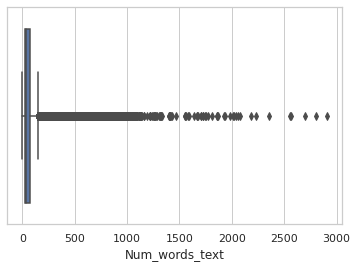

In [ ]:
sns.set(style="whitegrid")
sns.boxplot(x=df['Num_words_text'])

In [ ]:
df['Sentiment'] = df['Sentiment'].map({'positive':1, 'negative':0})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df.head()

,data/product_title,data/review_body,data/review_headline,Sentiment,Num_words_text
0,b'Teenage Mutant Ninja Turtles Boombox CD Play...,b'Does not work',b'One Star',0,3
1,b'4 Gauge Amp Kit Amplifier Install Wiring Com...,b'This is a great wiring kit i used it to set ...,b'Great kit',1,65
2,b'Travel Wall Charger fits Creative Zen Vision...,b'It works great so much faster than USB charg...,b'A/C Charger for Creative Zen Vision M',1,16
3,b'High Grade Robust 360\xc2\xb0 Adjustable Car...,b'This product was purchased to hold a monitor...,b'camera stand',1,29
4,b'HDE Multifunctional Bluetooth FM Audio Car K...,"b""it works but it has really bad sound quality...",b'bad sound quality',1,16


In [ ]:
df['short_review'] =df['data/review_body'].str.decode("utf-8")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df.head()

,data/product_title,data/review_body,data/review_headline,Sentiment,Num_words_text,short_review
0,b'Teenage Mutant Ninja Turtles Boombox CD Play...,b'Does not work',b'One Star',0,3,Does not work
1,b'4 Gauge Amp Kit Amplifier Install Wiring Com...,b'This is a great wiring kit i used it to set ...,b'Great kit',1,65,This is a great wiring kit i used it to set up...
2,b'Travel Wall Charger fits Creative Zen Vision...,b'It works great so much faster than USB charg...,b'A/C Charger for Creative Zen Vision M',1,16,It works great so much faster than USB charger...
3,b'High Grade Robust 360\xc2\xb0 Adjustable Car...,b'This product was purchased to hold a monitor...,b'camera stand',1,29,This product was purchased to hold a monitor o...
4,b'HDE Multifunctional Bluetooth FM Audio Car K...,"b""it works but it has really bad sound quality...",b'bad sound quality',1,16,it works but it has really bad sound quality. ...


# Text Preprocessing

Stemming and usual text data preprocessing using NLTK Library

In [ ]:
corpus = []
for i in range(0, 104975):
  review = re.sub('[^a-zA-Z]', ' ', df['short_review'][i])
  review = review.lower()
  review = review.split()
  ps = PorterStemmer()
  all_stopwords = stopwords.words('english')
  all_stopwords.remove('not')
  review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
  review = ' '.join(review)
  corpus.append(review)
#print(corpus)

In [ ]:
print(corpus[:4])

['not work', 'great wire kit use set pyle watt amp alpin sub work fine im not sure power cord length batteri back ground cord bit short that flaw gave star great kit', 'work great much faster usb charger buy glad', 'product purchas hold monitor desk connect secur camera door busi serv purpos perfectli']


# Tokenization

In [ ]:
vocab_size = 20000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 70000
test_size = 95000

In [ ]:
labels = df['Sentiment'].tolist()

We will split the dataset into Train, Validation and test datasets for avoiding overfitting situation

In [ ]:
training_sentences = corpus[0:training_size]
val_sentence       = corpus[training_size: test_size]
testing_sentences  = corpus[test_size:]
training_labels    = labels[0:training_size]
val_labels         = labels[training_size:test_size]
testing_labels     = labels[test_size:]

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(val_sentence)
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
sample_sentence = 'this is a very good product'
sent = tokenizer.texts_to_sequences([sample_sentence])
sample_pad = pad_sequences(sent, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(sent)

[[1, 1, 1, 1, 10, 9]]


In [ ]:
print(sample_pad.tolist())

[[1, 1, 1, 1, 10, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [ ]:
print(training_padded[:1])

[[3 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [ ]:
print(training_padded[:1].tolist())

[[3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [ ]:
print(training_sequences[:2])

[[3, 4], [6, 138, 483, 5, 80, 2102, 505, 147, 657, 248, 4, 101, 784, 3, 146, 55, 145, 699, 33, 42, 987, 145, 136, 331, 1106, 1125, 365, 153, 6, 483]]


In [ ]:
import io
import json
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

# Train Validation split

In [ ]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
val_padded      = np.array(val_padded)
val_labels      = np.array(val_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

# Model

In [ ]:
model = tf.keras.Sequential([
                             
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.4),
    #tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True),
    #tf.keras.layers.Flatten(),                         
    #tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    #tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           480000    
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               41472     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 529,793
Trainable params: 529,793
Non-trainable params: 0
__________________________________________________

In [ ]:
num_epochs = 8
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(val_padded, val_labels), verbose=1)

Epoch 1/8
2188/2188 [==============================] - 185s 83ms/step - loss: 0.3783 - accuracy: 0.8382 - val_loss: 0.2635 - val_accuracy: 0.8938
Epoch 2/8
2188/2188 [==============================] - 180s 82ms/step - loss: 0.2445 - accuracy: 0.9000 - val_loss: 0.2652 - val_accuracy: 0.8940
Epoch 3/8
2188/2188 [==============================] - 181s 83ms/step - loss: 0.2234 - accuracy: 0.9091 - val_loss: 0.2590 - val_accuracy: 0.8941
Epoch 4/8
2188/2188 [==============================] - 180s 82ms/step - loss: 0.2073 - accuracy: 0.9169 - val_loss: 0.2603 - val_accuracy: 0.8934
Epoch 5/8
2188/2188 [==============================] - 180s 82ms/step - loss: 0.1974 - accuracy: 0.9200 - val_loss: 0.2654 - val_accuracy: 0.8913
Epoch 6/8
2188/2188 [==============================] - 180s 82ms/step - loss: 0.1861 - accuracy: 0.9248 - val_loss: 0.2739 - val_accuracy: 0.8894
Epoch 7/8
2188/2188 [==============================] - 180s 82ms/step - loss: 0.1741 - accuracy: 0.9303 - val_loss: 0.2736 -

KeyboardInterrupt: ignored

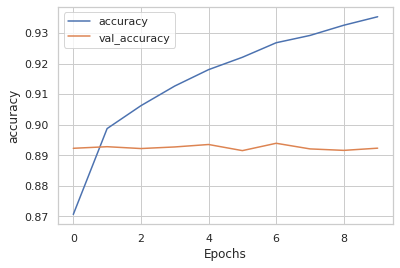

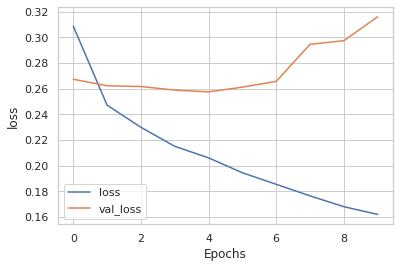

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

**Save the tokenizer with the tokenizer.to_json method**

In [ ]:
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

# Evaluation

In [ ]:
#sentence = ["The item is not so good", "working ok won't recommend"]
#sequences = tokenizer.texts_to_sequences(sentence)
#padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_pred = model.predict(testing_padded)

In [ ]:
print(test_pred[:20])

[[0.7310096 ]
 [0.9939679 ]
 [0.9865349 ]
 [0.99962306]
 [0.99046737]
 [0.09838387]
 [0.46860212]
 [0.98887956]
 [0.9363153 ]
 [0.999374  ]
 [0.99963844]
 [0.91318136]
 [0.13211067]
 [0.9963774 ]
 [0.9994184 ]
 [0.9989027 ]
 [0.9934001 ]
 [0.01420879]
 [0.84382993]
 [0.96695083]]


In [ ]:
print(testing_labels[:20])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]


In [ ]:
sample_text = 'A very good product'
seq = tokenizer.texts_to_sequences([sample_text])
pad = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = new_model.predict(pad)
print(pred[0])

[0.9114751]


In [ ]:
sample_text = ['bad product. worst']
seq = tokenizer.texts_to_sequences(sample_text)
pad = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(pad)
print(pred[0])

[0.00283695]


In [ ]:
def predict_text(text):
  sequences = tokenizer.texts_to_sequences([text])
  padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  return padded

In [ ]:
text = 'This is a very good item. I would recommend it'
new_pred = predict_text(text)
new_pred.tolist()
predictions = model.predict(new_pred)
if predictions>=0.3:
  out_label = 'Positive'
else:
  out_label = 'negative'
print(predictions[0])
print(out_label)

[0.95462656]
Positive


In [ ]:
# Save model
#model.save("amazon_review_classification_model2")

INFO:tensorflow:Assets written to: amazon_review_classification/assets


INFO:tensorflow:Assets written to: amazon_review_classification/assets


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!curl https://sdk.cloud.google.com | bash 1> /dev/null
!gcloud init

In [ ]:
# Copy model to bucket - https://cloud.google.com/storage/docs/uploading-objects#gsutil 
# Use "-r" for folders (r stands for recursive)
!gsutil cp -r amazon_review_classification gs://amazon_review_test

# BAG of Words

**Let's try the classification using bag of models instead of tokenizer**

We will try two classifier models for sentiment analysis: Naive Bayes and Logistic Regression

In [ ]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(corpus).toarray()
y = df.iloc[:, 3:4].values

In [ ]:
print(X[:2])
print('-----------')
print(y[:2])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
-----------
[[0]
 [1]]


In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)


In [ ]:
# Training the Naive Bayes model on the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 1]
 [1 1]
 [0 0]
 ...
 [1 1]
 [0 0]
 [1 1]]


In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[4345  650]
 [7298 8702]]


0.6214336746844487

**Building a logistic regression**

In [ ]:
# Training the Logistic Regression model on the Training set
from sklearn.linear_model import LogisticRegression
log_classifier = LogisticRegression(solver='lbfgs', max_iter=400)
log_classifier.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = log_classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 1]
 [1 1]
 [0 0]
 ...
 [1 1]
 [0 0]
 [1 1]]


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[ 3422  1573]
 [  833 15167]]


0.8854012860204811